In [1]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from fredapi import Fred
import api_keys
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import statsmodels.api as sm
from scipy.stats import anderson
import scipy.stats as stats
import estimation

# Data Import

In [2]:
# Twitter data
df = pd.read_csv("results\BTCTSI.csv")
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

# Getting btc data
start = df.index[0]
end = "2022-12-31" #df.index[-1]
start_day = start.strftime('%Y-%m-%d')
end_day = "2022-12-31" #end.strftime('%Y-%m-%d')
data = yf.download('BTC-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [3]:
R = pd.read_csv("data/t_bill.csv", index_col="Date")
lstm_prediction = pd.read_csv("data/LSTM_predictions.csv", index_col="index")

## Setting the estimation dataset, window size is i = 7, correpsonding to 1 week

In [14]:
# Create the dataset
i = 7
estimation_df = (data.loc[:,['Close']])
estimation_df['daily_rate'] = R.values
estimation_df['Sentiment'] = df.compound + (1 - df.compound.min())
estimation_df['rolling_Sentiment'] = np.log(estimation_df.Sentiment) #- np.log(estimation_df.Sentiment.rolling(i).mean()) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
#given_date = pd.to_datetime("2019-12-1")
#estimation_df = estimation_df[estimation_df.index > given_date]
estimation_df['deviation'] =  np.log(estimation_df.Close) - np.log(estimation_df.Close.rolling(i).mean())
estimation_df['y'] = np.log(1+estimation_df.daily_rate) + (estimation_df.deviation)
estimation_df['x0'] = estimation_df.deviation.shift(1)
estimation_df['x1'] = estimation_df.deviation.shift(3)
estimation_df['x2'] = estimation_df.rolling_Sentiment.shift(1)
estimation_df['x3'] = estimation_df.rolling_Sentiment.shift(3)
estimation_df = estimation_df.dropna()

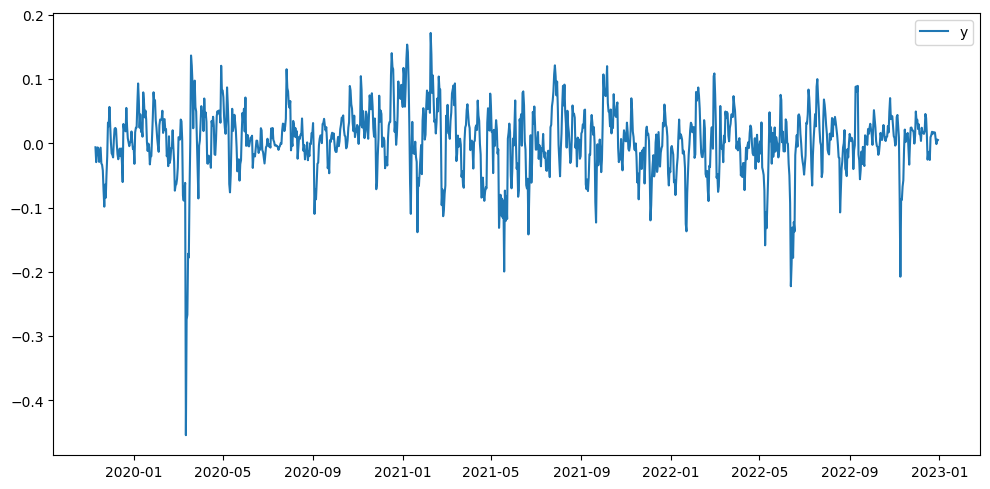

In [15]:
# Visualize the data
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(estimation_df.index, estimation_df.y, label="y")
fig.tight_layout()
plt.legend()
plt.show()

In [21]:
# Check some descriptive statistics
print(estimation_df.y.describe())
print(estimation_df.y.autocorr(1))

count    1147.000000
mean        0.003821
std         0.051509
min        -0.454159
25%        -0.018981
50%         0.006741
75%         0.031672
max         0.171665
Name: y, dtype: float64
0.7652200287244839


In [17]:
# Check for stationarity and homoskedasticity
print("ADF test for stationarity")
print(sm.tsa.stattools.adfuller(estimation_df.y))

ADF test for stationarity
(-12.518928166418013, 2.5741819841457327e-23, 4, 1142, {'1%': -3.436089106551049, '5%': -2.864074184091338, '10%': -2.568119264202968}, -4465.687635940046)


#### Stationarity
The first is the Augmented Dickey-Fuller test for testing the null hypothesis of unit roots. The returns are:
- The test statistic
- The ssociated p-value
- The number of lags used
- The number of observation
- Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)
- The maximized information criterion
The interpretation is that if the p-value is above the critival size then we cannot reject the null hypothesis. 
In our case the p-value is essentially 0, so we can safely reject it. The data is stationary.



In [18]:
print("ARCH test for homoskedasticity")
print(sm.stats.diagnostic.het_arch(estimation_df.y))

ARCH test for homoskedasticity
(285.4011550740258, 1.886586721354092e-55, 37.73627718357083, 3.68752433533115e-64)


#### Homoskedasticity
The second test is the Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH).
The returns are:
- Lagrange multiplier test statistic
- p-value for Lagrange multiplier test
- fstatistic for F test, alternative version of the same test based on F test for the parameter restriction
- pvalue for F testm

In [5]:
## Checking the correlation among variables
estimation_df.loc[:,['y', 'x0', 'x1', 'x2', 'x3']].corr()

,y,x0,x1,x2,x3
y,1.000000,0.763637,0.386188,0.128860,0.055216
x0,0.763637,1.000000,0.580189,0.145079,0.077720
x1,0.386188,0.580189,1.000000,0.010134,0.144881
x2,0.128860,0.145079,0.010134,1.000000,0.036984
x3,0.055216,0.077720,0.144881,0.036984,1.000000


In [7]:
# Performing the optimization
x_data = [estimation_df['x0'], estimation_df['x1'], estimation_df['x2'], estimation_df['x3']]
y_data = estimation_df['y']
bounds1 = ((-10.0, 10), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf))
popt, pcov = curve_fit(objevtive_function, x_data, y_data, p0 = [0.5, 0.5, -0.8])
#popt, pcov = curve_fit(two_type_beta_fixed, x_data, y_data, p0 = [0.5, 0.5])

In [8]:
# Printing the resulting parameters, and relative t-tests
print('paramters:',popt, 't-stats:', popt / np.sqrt(np.diagonal(pcov)))

paramters: [1.17018431 0.00981107 0.62520094] t-stats: [7.41993262 1.81926828 1.58613095]


In [153]:
frac1 = pd.DataFrame(two_model_fractions(x_data, *popt))
frac1.to_csv("fraction_two_types.csv")

c:\Users\tomma\OneDrive\Desktop\Work\Paper_1\paper1_venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


c:\Users\tomma\OneDrive\Desktop\Work\Paper_1\paper1_venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


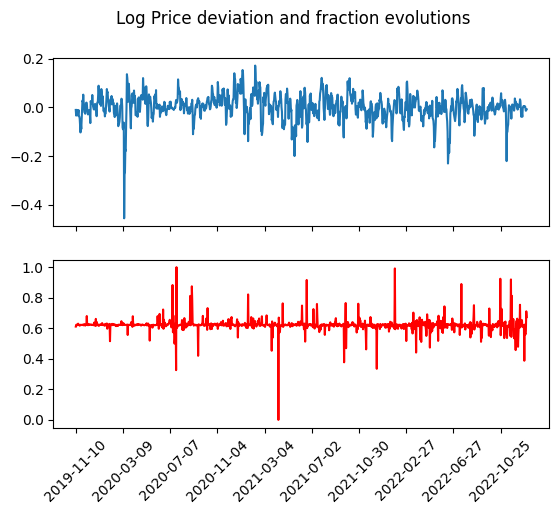

In [426]:
# Fraction evolution
frac1 = two_model_fractions(x_data, *popt, 0.5)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Log Price deviation and fraction evolutions')
ax1.plot(y_data)
ax2.plot(frac1, color = 'red')

# get the x-axis dates and format them
x_dates = ax2.get_xticks()
date_fmt = mdates.DateFormatter('%Y-%m-%d')

# set the ticker to show only one date every 6 months
tick_spacing = 120
ax2.xaxis.set_major_locator(ticker.IndexLocator(base=tick_spacing, offset=0))
ax2.xaxis.set_major_formatter(date_fmt)
ax2.tick_params(axis='x', rotation=45)
# show the plot
plt.show()

In [319]:
# Printing performance measures for the fit
#### Adjusted R-squared
y_pred = objevtive_function(x_data, *popt)
#y_pred = two_type_beta_fixed(x_data, *popt)
residuals = y_pred - y_data
# Residual sum of squares
rss = np.sum((residuals)**2)
# Total sum of squares
tss = np.sum((y_data - np.mean(y_data))**2)
# Number of observations
n = len(y_data)
# Number of parameters
k = len(popt)
# R-squared
r_squared = 1 - (rss / tss)
# Adjusted R-squared
adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
#Akaike criterion
AIC = 2 * k + n*np.log(np.var(residuals))
print('r2:',r_squared, 'adjusted r2:', adj_r_squared, 'AIC:', AIC)

r2: 0.591544780055743 adjusted r2: 0.5904727191110073 AIC: -7812.145335108351


In [320]:
# Residuals check 
residuals = y_pred - y_data
residuals = residuals[residuals < 0.3]
print(residuals.mean(), residuals[0:300].var(), residuals[300:].var())
# Calculate the parameters for the normal distribution PDF
mean, std = np.mean(residuals), np.std(residuals)
pdf = stats.t.pdf(bins, 10*6, mean, std)

n, bins, patches = plt.hist(residuals, bins=50, density=True, alpha=0.75, color='blue')
# Add the normal distribution PDF on top of the histogram
plt.plot(bins, pdf, 'r', linewidth=2)


-0.0005737382072502936 0.0007609328911580656 0.0010215553920623658


NameError: name 'bins' is not defined

## Bootstrapping standard errors

In [44]:
indices = np.random.randint(0, 10, 10)
print(indices)
estimation_df.iloc[100:100+20]

[6 8 3 4 4 8 8 3 5 7]


,Close,daily_rate,Sentiment,rolling_Sentiment,deviation,y,x0,x1,x2,x3
Date,,,,,,,,,,
2020-02-18,10141.996094,0.004027,1154.3375,0.031753,0.006861,0.010880,-0.039654,-0.024226,-0.038456,-0.048677
2020-02-19,9633.386719,0.004027,1098.0176,-0.009159,-0.034716,-0.030697,0.006861,-0.017112,0.031753,-0.044382
2020-02-20,9608.475586,0.004000,1011.4692,-0.076783,-0.028589,-0.024597,-0.034716,-0.039654,-0.009159,-0.038456
2020-02-21,9686.441406,0.003918,1042.6354,-0.036293,-0.011426,-0.007516,-0.028589,0.006861,-0.076783,0.031753
2020-02-22,9663.181641,0.003918,1024.9192,-0.043513,-0.010526,-0.006616,-0.011426,-0.034716,-0.036293,-0.009159
2020-02-23,9924.515625,0.003918,1060.9187,-0.006156,0.016304,0.020214,-0.010526,-0.028589,-0.043513,-0.076783
2020-02-24,9650.174805,0.003699,1048.6377,-0.013595,-0.011143,-0.007451,0.016304,-0.011426,-0.006156,-0.036293
2020-02-25,9341.705078,0.003562,1066.4699,0.015147,-0.031845,-0.028290,-0.011143,-0.010526,-0.013595,-0.043513
2020-02-26,8820.522461,0.003452,1084.1690,0.033491,-0.077139,-0.073693,-0.031845,0.016304,0.015147,-0.006156


In [45]:
# Bootstrap the standard errors
block_length = int(np.floor(len(estimation_df)*0.6))
N_bootstraps = 2000
params_bootstrapped = np.zeros((N_bootstraps, 3))
adj_r2 = np.zeros((N_bootstraps, 1))
for i in range(N_bootstraps):
    
    start = np.random.randint(0, estimation_df.shape[0] - block_length)
    # Select the block
    
    estimation_df_boost = estimation_df.iloc[start:start + block_length]
    x = [estimation_df_boost['x0'], estimation_df_boost['x1'], estimation_df_boost['x2'], estimation_df_boost['x3']]
    y = estimation_df_boost['y']
    try:
        params, pcov = curve_fit(objevtive_function, x, y, p0 = [0.5,0.5,0.8])
        #params, pcov = curve_fit(two_type_beta_fixed, x, y, p0 = [0.5,0.5])
    except:
        params, pcov = np.zeros(3), np.zeros((3,3))
        #params, pcov = np.zeros(2), np.zeros((2,2))
    params_bootstrapped[i, :] = params
    #y_pred = objevtive_function(x, *params)
    y_pred = two_type_beta_fixed(x, *params)
    residuals = y_pred - y
    rss = np.sum((residuals)**2)
    tss = np.sum((y- np.mean(y))**2)
    n = len(y)
    k = len(params)
    r_squared = 1 - (rss / tss)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
    adj_r2[i,:] = adj_r_squared

C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2647756047.py:3: RuntimeWarning: overflow encountered in exp
  return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))
c:\Users\tomma\OneDrive\Desktop\Work\Paper_1\paper1_venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
len(params_bootstrapped), block_length

(2000, 688)

In [47]:
# Calculate the standard errors and confidence intervals
params_bootstrapped = params_bootstrapped[~np.all(params_bootstrapped == 0, axis=1)]
params_mean = np.mean(params_bootstrapped, axis=0)
params_std = np.std(params_bootstrapped, axis=0)
params_lower = np.percentile(params_bootstrapped, 2.5, axis=0)
params_upper = np.percentile(params_bootstrapped, 97.5, axis=0)
mean_adj_r2 = np.mean(adj_r2)
print(params_mean, params_mean/params_std, mean_adj_r2)

[1.18886102 0.01009791 0.67092931] [15.07495094  3.15354963  0.87849146] 0.5891572240974152


In [382]:
t_statistic = params_mean / params_std
degree_freedom = block_length - 3
p_values = stats.t.sf(np.abs(t_statistic), degree_freedom)*2

print(p_values)

[1.64993220e-17 1.12905190e-02 5.07974963e-01]


In [48]:
## Inspecting the role of different Betas on the estimation result
def beta_adj_r(beta_vector):
    adj_r_squared_vector = []
    params = []
    errors = []
    AIC_vector = []
    
    for beta_i in beta_vector:
        beta = beta_i
        #Defining the objective function
        def objective_function_full(params, x, y):
            g = params[0]
            b = params[1]
            c = params[2]
            return  -y + c + g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))

        def objective_function(params, x, y):
            g = params[0]
            b = 1.0
            c = params[1]
            return  -y + c + g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))
        
        def function_full(x, g, b):
            return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))
            
        # Perform the optimization
        x_data = [estimation_df['x0'], estimation_df['x1'], estimation_df['x2'], estimation_df['x3']]
        y_data = estimation_df['y']
        
        try:
            popt, pcov = curve_fit(function_full, x_data, y_data, p0 = [0.5, 0.5])
        except:
            popt, pcov = np.zeros(2), np.zeros((2,2))
        #st erorrs
        errors.append(np.sqrt(np.diagonal(pcov)))

        # Perform the optimization
        
        # bounds = ([-10.0,-np.inf, -np.inf], [10.0,np.inf, np.inf])
        # result = least_squares(objective_function_full, [ 0.5, 0.5, 0.5], args=(x_data, y_data))
        # residuals = objective_function_full(result.x, x_data, y_data)

        # result = least_squares(objective_function, [0.5,0.0], args=(x_data, y_data))
        # residuals = objective_function(result.x, x_data, y_data)

        #### Adjusted R-squared
        #y_pred = (objective_function_full(result.x, x_data, y_data) + y_data)
        y_pred = function_full(x_data, *popt )#(objective_function_full(result.x, x_data, y_data) + y_data)
        residuals = y_pred - y_data
        # Residual sum of squares
        #rss = np.sum((objective_function_full(result.x, x_data, y_data))**2)
        rss = np.sum((residuals)**2)
        # Total sum of squares
        tss = np.sum((y_data - np.mean(y_data))**2)

        # Number of observations
        n = len(y_data)

        # Number of params
        if beta == 0.0:
            k = len(popt)
        else:
            k = len(popt) + 1

        # R-squared
        r_squared = 1 - (rss / tss)

        # Adjusted R-squared
        adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
        #Akaike criterion
        AIC = 2 * k + n*np.log(rss/n)
        adj_r_squared_vector.append(adj_r_squared)
        AIC_vector.append(AIC)
        params.append(popt)


        #Standard errors
        # J = result.jac
        # cov = np.linalg.inv(J.T.dot(J))
        # errors.append(np.sqrt(np.diagonal(cov)))

    return adj_r_squared_vector, params, errors, AIC_vector

In [49]:
#Computing the results
beta_vector = np.arange(0.00,2.0,0.05)
adj_r2, params, errors, aic = beta_adj_r(beta_vector)
#Params and errors
g = np.array([array[0] for array in params])
b = np.array([array[1] for array in params])
g_errors = np.array([array[0] for array in errors])
b_errors = np.array([array[1] for array in errors])

C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\1341172314.py:24: RuntimeWarning: overflow encountered in exp
  return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))


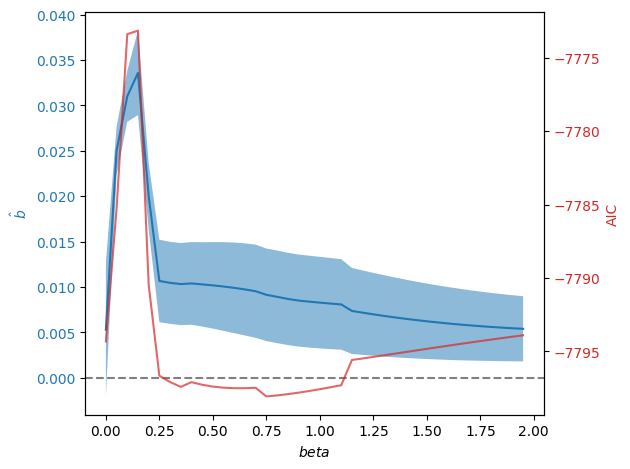

In [51]:
### Plotting
t = beta_vector
data1 = b
data2 = aic

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('$beta$')
ax1.set_ylabel('$\hat{b}$', color=color)
ax1.plot(t, data1, color=color)
ax1.axhline(y=0.0, color='gray', linestyle='--')
ax1.fill_between(t, data1-b_errors, data1+b_errors, alpha = 0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('AIC', color=color )  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, alpha = 0.7)
ax2.tick_params(axis='y', labelcolor=color)



fig.tight_layout()
fig.savefig('AIC_b_estimate.png', dpi = 300)

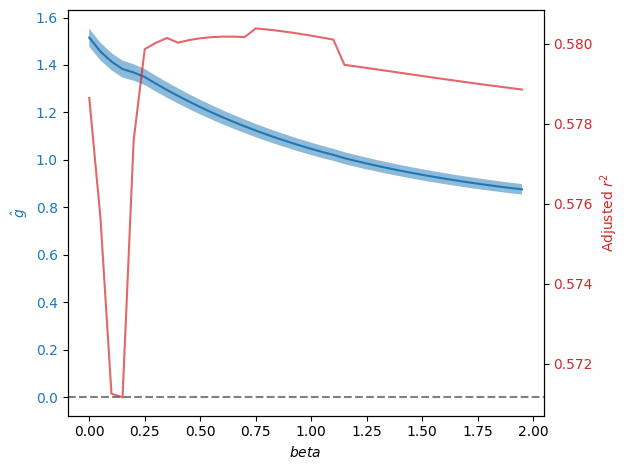

In [52]:
### Plotting
t = beta_vector
data1 = g
data2 = adj_r2

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('$beta$')
ax1.set_ylabel('$\hat{g}$', color=color)
ax1.plot(t, data1, color=color)
ax1.axhline(y=0.0, color='gray', linestyle='--')
ax1.fill_between(t, data1-g_errors, data1+g_errors, alpha = 0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Adjusted $r^2$', color=color )  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, alpha = 0.7)
ax2.tick_params(axis='y', labelcolor=color)



fig.tight_layout()
fig.savefig('Adjr2_g_estimate.png', dpi = 300)

## Inspecting the window size, on the estimation result

We consider all startegies in deviation from a fundamental price, and see how this affects the estimation result.

In [344]:
def rolling_selection(rolling_window_size):
    results = []
    adj_r2 = []
    errors = []
    linear_r2 = []
    for window in rolling_window_size:
        i = window
        # Create the dataset
        estimation_df = (data.loc[:,['Close']])
        estimation_df['daily_rate'] = 1 #R.values
        estimation_df['Sentiment'] = df.compound + (1 - df.compound.min())
        estimation_df['rolling_Sentiment'] = np.log(estimation_df.Sentiment) - np.log(estimation_df.Sentiment.rolling(i).mean()) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
        #given_date = pd.to_datetime("2019-12-1")
        #estimation_df = estimation_df[estimation_df.index > given_date]
        estimation_df['deviation'] = np.log((1+estimation_df.daily_rate)*estimation_df.Close) - np.log(estimation_df.Close.rolling(i).mean())
        estimation_df['y'] = (estimation_df.deviation)
        estimation_df['x0'] = estimation_df.deviation.shift(1)
        estimation_df['x1'] = estimation_df.deviation.shift(3)
        estimation_df['x2'] = estimation_df.rolling_Sentiment.shift(1)
        estimation_df['x3'] = estimation_df.rolling_Sentiment.shift(3)
        estimation_df = estimation_df.dropna()
        #Defining the objective function
        def objective_function_full(params, x, y):
            g = params[0]
            b = params[1]
            #c = params[2]
            beta = params[2]
            return  -y + g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))
        def function_full(x, g, b, beta):
            return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))

        def function_only_b(x, b1, b2, beta):
            return  b1*x[2]*(1/(1+np.exp(beta*((b2 - b1)/(b1 + b2))))) + b2*x[2] * (1-(1/(1+np.exp(beta*((b2 - b1)/(b1 + b2))))))
            
        # Perform the optimization
        x_data = [estimation_df['x0'], estimation_df['x1'], estimation_df['x2'], estimation_df['x3']]
        y_data = estimation_df['y']
        # bounds = ([-10.0,-np.inf, 0.0], [10.0,np.inf, np.inf])
        # result = least_squares(objective_function_full, [ 0.5, 0.5, 0.8], bounds = bounds, args=(x_data, y_data))
        # results.append(result.x)
        
        try:
            popt, pcov = curve_fit(function_full, x_data, y_data, p0 = [0.5, 0.5, 0.8])
        except:
            print('error, setting params to 0')
            popt, pcov = np.zeros(3), np.zeros((3,3))
        results.append(popt)
        #st erorrs
        errors.append(np.sqrt(np.diagonal(pcov)))



        # #Standard errors
        # J = result.jac
        # cov = np.linalg.inv(J.T.dot(J))
        # errors.append(np.sqrt(np.diagonal(cov)))

        #### Adjusted R-squared
        y_pred = function_full(x_data, *popt)#(objective_function_full(result.x, x_data, y_data) + y_data)
        residuals = y_pred - y_data #objective_function_full(result.x, x_data, y_data)        
        # Residual sum of squares
        rss = np.sum((residuals)**2)
        # Total sum of squares
        tss = np.sum((y_data - np.mean(y_data))**2)
        # Number of observations
        n = len(y_data)
        # Number of independent variables
        k = len(popt) 
        # R-squared
        r_squared = 1 - (rss / tss)
        # Adjusted R-squared
        adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
        adj_r2.append(adj_r_squared)

        #Linear r2
        # adding the constant term
        x = sm.add_constant(estimation_df[['x0', 'x2']])
        y = estimation_df['y'] 
        OLS_result = sm.OLS(y, x).fit()
        linear_r2.append(OLS_result.rsquared_adj)

    return results, errors, adj_r2, linear_r2

C:\Users\tomma\AppData\Local\Temp\ipykernel_10624\432978312.py:30: RuntimeWarning: overflow encountered in exp
  return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))
C:\Users\tomma\AppData\Local\Temp\ipykernel_10624\432978312.py:30: RuntimeWarning: overflow encountered in exp
  return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))
C:\Users\tomma\AppData\Local\Temp\ipykernel_10624\432978312.py:30: RuntimeWarning: overflow encountered in exp
  return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))


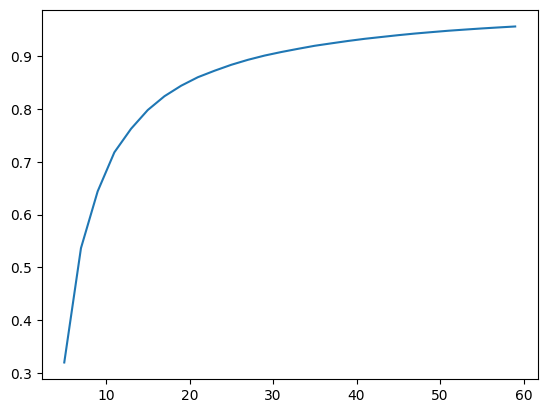

In [350]:
## Visualizing the r-squared
#Visualizing
window_vector = np.arange(5,60,2)
params, st_errors, r2, linear_r2 = rolling_selection(window_vector)
plt.plot(window_vector, r2, label = 'NLS')
#plt.plot(window_vector, linear_r2, label = 'linear')

# With returns

In [138]:
# Create the dataset
return_df = (data.loc[:,['Close']])
return_df['daily_rate'] = R.values
return_df['Sentiment'] = df.compound + (1 - df.compound.min())
return_df['log_Sentiment'] = np.log(estimation_df.Sentiment) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
#given_date = pd.to_datetime("2019-12-1")
#estimation_df = estimation_df[estimation_df.index > given_date]
return_df['returns'] = np.log(return_df.Close)
return_df['y'] = return_df.returns 
return_df['x0'] = return_df.returns.shift(1)
return_df['x1'] = return_df.returns.shift(3)
return_df['x2'] = return_df.Sentiment.shift(1)
return_df['x3'] = return_df.Sentiment.shift(3)
return_df = return_df.dropna()

(29.2588923692183, array([0.574, 0.654, 0.784, 0.915, 1.088]))

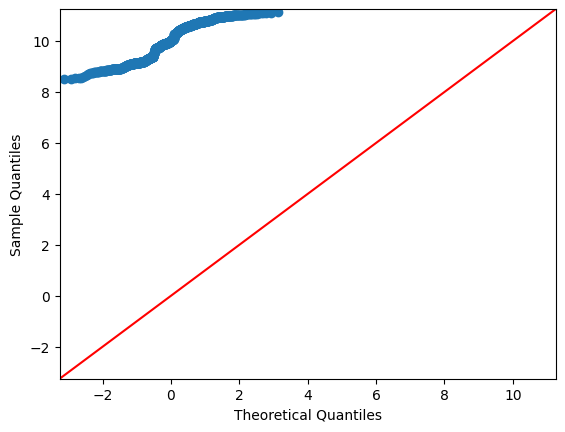

In [139]:
#Check normality of log-returns
sm.qqplot(return_df.y, line ='45')
res = anderson(return_df.y, dist='norm')
res.statistic, res.critical_values

In [140]:
# Performing the optimization
x_data = [return_df['x0'], return_df['x1'], return_df['x2'], return_df['x3']]
y_data = return_df['y']
bounds1 = ((-10.0, 10), (-np.inf, np.inf), (-np.inf, np.inf), (0.0, 10.0))
popt1, pcov1 = curve_fit(objevtive_function, x_data, y_data, p0 = [0.5, 0.5, 0.8])

In [141]:
# Printing the resulting parameters, and relative t-tests
print('paramters:',popt1, 't-stats:', popt1 / np.sqrt(np.diagonal(pcov1)))

paramters: [1.86102058e+00 5.96009509e-06 1.49086060e-01] t-stats: [2.2296203  0.67924724 0.15378041]


In [142]:
# Printing performance measures for the fit
#### Adjusted R-squared
y_pred = objevtive_function(x_data, *popt1)
residuals = y_pred - y_data
# Residual sum of squares
rss = np.sum((residuals)**2)
# Total sum of squares
tss = np.sum((y_data - np.mean(y_data))**2)
# Number of observations
n = len(y_data)
# Number of parameters
k = len(popt)
# R-squared
r_squared = 1 - (rss / tss)
# Adjusted R-squared
adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
#Akaike criterion
AIC = 2 * k + n*np.log(np.var(residuals))
print('r2:',r_squared, 'adjusted r2:', adj_r_squared, 'AIC:', AIC)

r2: 0.9970964605596869 adjusted r2: 0.9970888397212609 AIC: -7478.580262358118


# Weekly Frequency

In [162]:
# Getting btc data
data_week = yf.download('BTC-USD', start="2019-11-01", end=end, interval="1wk")
Weekly_BiTSI = pd.read_csv("results\Weekly_BiTSI.csv", index_col="Date")

[*********************100%***********************]  1 of 1 completed


In [267]:
weekly_tb_data = fred.get_series('DGS1', observation_start='2019-11-05', observation_end='2022-12-31', frequency='w')

In [269]:
weekly_tb_data = 1 + (weekly_tb_data[:-1])/5200

In [270]:
weekly_tb_data

2019-11-08    1.000304
2019-11-15    1.000300
2019-11-22    1.000298
2019-11-29    1.000306
2019-12-06    1.000302
                ...   
2022-12-02    1.000910
2022-12-09    1.000908
2022-12-16    1.000896
2022-12-23    1.000892
2022-12-30    1.000910
Length: 165, dtype: float64

In [332]:
# Create the dataset
i = 4
weekly_estimation_df = (data_week.loc[:,['Close']])
weekly_estimation_df['weekly_rate'] = weekly_tb_data.values
weekly_estimation_df['Sentiment'] = (Weekly_BiTSI.BiTSI + (1 - Weekly_BiTSI.BiTSI.min())).values
weekly_estimation_df['rolling_Sentiment'] = np.log(weekly_estimation_df.Sentiment) - np.log(weekly_estimation_df.Sentiment.rolling(i).mean()) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
#given_date = pd.to_datetime("2019-12-1")
#estimation_df = estimation_df[estimation_df.index > given_date]
weekly_estimation_df['deviation'] = np.log(weekly_estimation_df.Close) - np.log(weekly_estimation_df.Close.rolling(i).mean())
weekly_estimation_df['y'] = np.log(weekly_estimation_df.weekly_rate*weekly_estimation_df.Close) - np.log(weekly_estimation_df.Close.rolling(i).mean())
weekly_estimation_df['x0'] = weekly_estimation_df.deviation.shift(1)
weekly_estimation_df['x1'] = weekly_estimation_df.deviation.shift(3)
weekly_estimation_df['x2'] = weekly_estimation_df.rolling_Sentiment.shift()
weekly_estimation_df['x3'] = weekly_estimation_df.rolling_Sentiment.shift(2)
weekly_estimation_df = weekly_estimation_df.dropna()


In [333]:
## Checking the correlation among variables
weekly_estimation_df.loc[:,['y', 'x0', 'x1', 'x2', 'x3']].corr()

,y,x0,x1,x2,x3
y,1.000000,0.642828,0.044334,0.181223,0.181302
x0,0.642828,1.000000,0.275482,0.127295,0.180905
x1,0.044334,0.275482,1.000000,0.027941,0.110628
x2,0.181223,0.127295,0.027941,1.000000,0.192262
x3,0.181302,0.180905,0.110628,0.192262,1.000000


([<matplotlib.lines.Line2D at 0x152c8df5690>], 159)

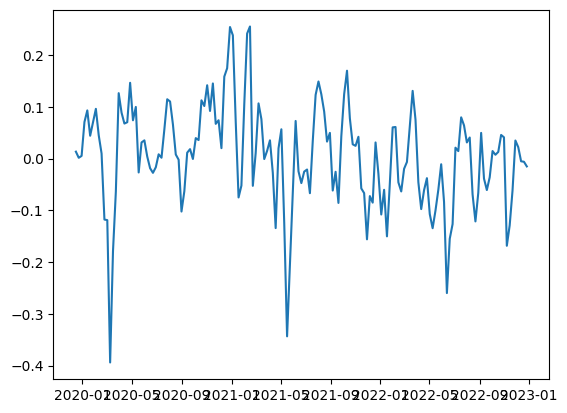

In [334]:
plt.plot(weekly_estimation_df.y), len(weekly_estimation_df.y)

In [335]:
# Performing the optimization
weekly_x_data = [weekly_estimation_df['x0'], weekly_estimation_df['x1'], weekly_estimation_df['x2'], weekly_estimation_df['x3']]
weekly_y_data = weekly_estimation_df['y']
bounds = ([-10.1, -10.1, 0.0], [10.0, 10.0, 10.0])
weekly_popt, weekly_pcov = curve_fit(objevtive_function, weekly_x_data, weekly_y_data, p0 = [0.5, 0.5, 1.2], bounds=bounds)

C:\Users\tomma\AppData\Local\Temp\ipykernel_10624\689731694.py:3: RuntimeWarning: overflow encountered in exp
  return  g*x[0]*(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))) + b*x[2] * (1-(1/(1+np.exp(beta*((b*x[3] - g*x[1])/(b*x[3] + g*x[1]))))))


In [336]:
# Printing the resulting parameters, and relative t-tests
print('paramters:',weekly_popt, 't-stats:', weekly_popt / np.sqrt(np.diagonal(weekly_pcov)))

paramters: [1.22065666 0.0348584  0.07042134] t-stats: [7.18632096 2.05467098 0.31733395]


In [472]:
# Printing performance measures for the fit
#### Adjusted R-squared
y_pred = objevtive_function(weekly_x_data, *weekly_popt)
weekly_residuals = y_pred - weekly_y_data
# Residual sum of squares
weekly_rss = np.sum((weekly_residuals)**2)
# Total sum of squares
weekly_tss = np.sum((weekly_y_data - np.mean(weekly_y_data))**2)
# Number of observations
weekly_n = len(weekly_y_data)
# Number of parameters
weekly_k = len(weekly_popt)
# R-squared
weekly_r_squared = 1 - (weekly_rss / weekly_tss)
# Adjusted R-squared
weekly_adj_r_squared = 1 - (1 - weekly_r_squared) * ((weekly_n - 1) / (weekly_n - weekly_k - 1))
#Akaike criterion
weekly_AIC = 2 * weekly_k + n*np.log(np.var(weekly_residuals))
print('r2:',weekly_r_squared, 'adjusted r2:', weekly_adj_r_squared, 'AIC:', weekly_AIC)

r2: 0.42321284177732454 adjusted r2: 0.4120492193601115 AIC: -5934.281373185316


# Estimation of the three type model with fundamentalist agent

In [109]:
# Create the dataset
i = 2
estimation_df = (data.loc[:,['Close']])
estimation_df['daily_rate'] = 0#R.values
estimation_df['Sentiment'] = df.compound + (1 - df.compound.min())
estimation_df['rolling_Sentiment'] = np.log(estimation_df.Sentiment) #- np.log(estimation_df.Sentiment.rolling(i).mean()) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
#given_date = pd.to_datetime("2019-12-1")
#estimation_df = estimation_df[estimation_df.index > given_date]
estimation_df['deviation'] = np.log(estimation_df.Close) - np.log(estimation_df.Close.rolling(i).mean())
estimation_df['y'] = np.log((1+estimation_df.daily_rate)) + (estimation_df.deviation)
estimation_df['x0'] = estimation_df.deviation.shift(1)
estimation_df['x1'] = np.log((1+estimation_df.daily_rate)) + estimation_df.deviation.shift(2)
estimation_df['x2'] = estimation_df.deviation.shift(3)
estimation_df['x3'] = estimation_df.rolling_Sentiment.shift(1)
estimation_df['x4'] = estimation_df.rolling_Sentiment.shift(3)
estimation_df['x5'] = np.log(estimation_df.Close.rolling(i).mean())
estimation_df['x6'] = np.log(estimation_df.Close.shift(2).rolling(i).mean())
window_size = 10
estimation_df['term_1'] = (estimation_df.x0*estimation_df.x2).rolling(window_size).mean()#corresponds to sum of (x_t-1 * x_t-3), will be multiplied by g
estimation_df['term_2'] = (estimation_df.x1* estimation_df.x2).rolling(window_size).mean() #corresponds to sum of (Rx_t-2 * x_t-3), will be multiplied by g
estimation_df['term_3'] = (estimation_df.x0* estimation_df.x4).rolling(window_size).mean() #corresponds to sum of (x_t-1 * y_t-3), will be multiplied by b
estimation_df['term_4'] = (estimation_df.x1* estimation_df.x4).rolling(window_size).mean() #corresponds to sum of (Rx_t-2 * y_t-3), will be multiplied by b
estimation_df['term_5'] = (estimation_df.x1* estimation_df.x1).rolling(window_size).mean() #corresponds to sum of (Rx_t-2 * R_x_t-2)
estimation_df['term_6'] = (estimation_df.x0* estimation_df.x1).rolling(window_size).mean() #corresponds to sum of (x_t-1 * R_x_t-2)
estimation_df = estimation_df.dropna()

In [110]:
## Checking the correlation among variables
estimation_df.loc[:,['y', 'x0', 'x1', 'x2', 'x3', 'x4','x5', 'x6']].corr()

,y,x0,x1,x2,x3,x4,x5,x6
y,1.000000,-0.064052,0.049413,-0.020016,0.024826,0.017059,-0.011904,-0.036464
x0,-0.064052,1.000000,-0.064048,0.049403,0.147577,-0.008720,0.013639,-0.036632
x1,0.049413,-0.064048,1.000000,-0.064123,0.086507,0.024939,0.013022,-0.012022
x2,-0.020016,0.049403,-0.064123,1.000000,0.033668,0.148006,0.014636,0.014381
x3,0.024826,0.147577,0.086507,0.033668,1.000000,0.462894,0.314874,0.303210
x4,0.017059,-0.008720,0.024939,0.148006,0.462894,1.000000,0.316155,0.314997
x5,-0.011904,0.013639,0.013022,0.014636,0.314874,0.316155,1.000000,0.997976
x6,-0.036464,-0.036632,-0.012022,0.014381,0.303210,0.314997,0.997976,1.000000


In [111]:
# Performing the optimization
x_data = [estimation_df['x0'], estimation_df['x1'], estimation_df['x2'], estimation_df['x3'], estimation_df['x4'], estimation_df['x5'], estimation_df['x6'],
          estimation_df['term_1'], estimation_df['term_2'], estimation_df['term_3'], estimation_df['term_4'], estimation_df['term_5'], estimation_df['term_6']]
y_data = estimation_df['y']
bounds1 = ((-np.inf, -np.inf , 0.0), (np.inf, np.inf, 100.0))
popt, pcov = curve_fit(fundamentalist_fitness_moving_avg, x_data, y_data, p0 = [0.5, 0.5, 0.8], bounds = bounds1)
#popt, pcov = curve_fit(fundamentalist_beta_fixed, x_data, y_data, p0 = [0.5, 0.5])

In [112]:
# Printing the resulting parameters, and relative t-tests
print('paramters:', (popt.round(4)), 't-stats:', popt / np.sqrt(np.diagonal(pcov)))

paramters: [-1.923e-01  1.000e-04  0.000e+00] t-stats: [-2.13936825e+00  2.33309057e-01  1.58656974e-13]


In [210]:
frac2 = fundamentalist_fractions(x_data, 1.8041, 0.0178, 0.0015)

In [220]:
fundamentalists_fractions = pd.DataFrame({'trend_follower': frac2[0], 'trend_bias': frac2[1], 'fundamentalist': frac2[2]})
fundamentalists_fractions.to_csv("fractions_fundamentalist.csv")

In [43]:
# Printing performance measures for the fit
#### Adjusted R-squared
y_pred = fundamentalist_full(x_data, *popt)
#y_pred = fundamentalist_beta_fixed(x_data, *popt)
residuals = y_pred - y_data
# Residual sum of squares
rss = np.sum((residuals)**2)
# Total sum of squares
tss = np.sum((y_data - np.mean(y_data))**2)
# Number of observations
n = len(y_data)
# Number of parameters
k = len(popt)
# R-squared
r_squared = 1 - (rss / tss)
# Adjusted R-squared
adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
#Akaike criterion
AIC = 2 * k + n*np.log(np.var(residuals))
print('r2:',r_squared, 'adjusted r2:', adj_r_squared, 'AIC:', AIC)

r2: 0.5848770575753679 adjusted r2: 0.5837874960466942 AIC: -7793.675131442067


In [201]:
## Inspecting the role of different Betas on the estimation result
def fundamentalist_beta_adj_r(beta_vector):
    adj_r_squared_vector = []
    params = []
    errors = []
    AIC_vector = []
    
    for beta_i in beta_vector:
        beta = beta_i
        def fundamentalist_beta_fixed(x, g, b, beta = beta):
            prof1 = (g*x[2] - x[1])/(g*x[2] + b * x[4] - 3*x[1])
            prof2 = (b * x[4]- x[1])/(g*x[2] + b * x[4] - 3*x[1])
            prof3 = (0- x[1])/(g*x[2] + b * x[4] - 3*x[1])
            frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
            frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
            frac3 = np.exp(beta*prof3)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
            return g*x[0] * frac1 + b*x[3] * frac2
        
        try:
            popt, pcov = curve_fit(fundamentalist_beta_fixed, x_data, y_data, p0 = [0.5, 0.5])
        except:
            popt, pcov = np.zeros(2), np.zeros((2,2))
        #st erorrs
        errors.append(np.sqrt(np.diagonal(pcov)))
        y_pred = fundamentalist_beta_fixed(x_data, *popt )#(objective_function_full(result.x, x_data, y_data) + y_data)
        residuals = y_pred - y_data
        # Residual sum of squares
        #rss = np.sum((objective_function_full(result.x, x_data, y_data))**2)
        rss = np.sum((residuals)**2)
        # Total sum of squares
        tss = np.sum((y_data - np.mean(y_data))**2)

        # Number of observations
        n = len(y_data)

        # Number of params
        if beta == 0.0:
            k = len(popt)
        else:
            k = len(popt) + 1

        # R-squared
        r_squared = 1 - (rss / tss)

        # Adjusted R-squared
        adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
        #Akaike criterion
        AIC = 2 * k + n*np.log(rss/n)
        adj_r_squared_vector.append(adj_r_squared)
        AIC_vector.append(AIC)
        params.append(popt)


    return adj_r_squared_vector, params, errors, AIC_vector

In [202]:
#Computing the results
beta_vector = np.arange(0.00,2.0,0.05)
adj_r2, params, errors, aic = fundamentalist_beta_adj_r(beta_vector)
#Params and errors
g = np.array([array[0] for array in params])
b = np.array([array[1] for array in params])
g_errors = np.array([array[0] for array in errors])
b_errors = np.array([array[1] for array in errors])

C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2238160506.py:14: RuntimeWarning: overflow encountered in exp
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2238160506.py:15: RuntimeWarning: overflow encountered in exp
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2238160506.py:15: RuntimeWarning: invalid value encountered in divide
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2238160506.py:16: RuntimeWarning: overflow encountered in exp
  frac3 = np.exp(beta*prof3)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2238160506.py:16: RuntimeWarning: invalid value encountered in divide
  frac3 = np.exp(beta*prof3)/(np.exp(beta*prof1) + np.ex

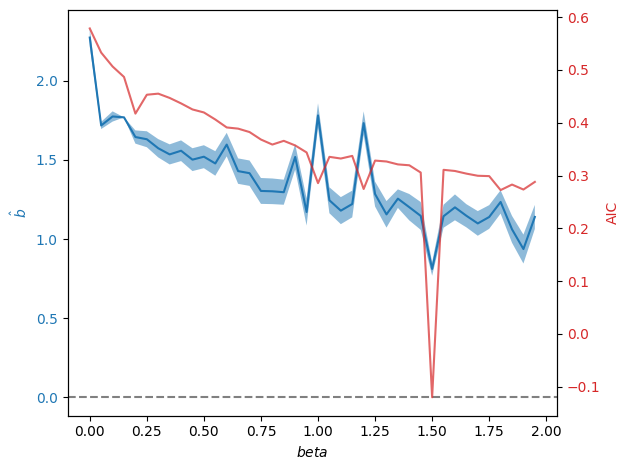

In [203]:
### Plotting
t = beta_vector
data1 = g
data2 = adj_r2

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('$beta$')
ax1.set_ylabel('$\hat{b}$', color=color)
ax1.plot(t, data1, color=color)
ax1.axhline(y=0.0, color='gray', linestyle='--')
ax1.fill_between(t, data1-g_errors, data1+g_errors, alpha = 0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('AIC', color=color )  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, alpha = 0.7)
ax2.tick_params(axis='y', labelcolor=color)



fig.tight_layout()
#fig.savefig('AIC_b_estimate.png', dpi = 300)

# Bootstrapping

In [204]:
# Bootstrap the standard errors
block_length = int(np.floor(len(estimation_df)*0.6))
N_bootstraps = 2000
params_bootstrapped = np.zeros((N_bootstraps, 3))
adj_r2 = np.zeros((N_bootstraps, 1))
for i in range(N_bootstraps):
    
    start = np.random.randint(0, estimation_df.shape[0] - block_length)
    # Select the block
    
    estimation_df_boost = estimation_df.iloc[start:start + block_length]
    x = [estimation_df_boost['x0'], estimation_df_boost['x1'], estimation_df_boost['x2'], estimation_df_boost['x3'], estimation_df_boost['x4']]
    y = estimation_df_boost['y']
    try:
        params, pcov = curve_fit(fundamentalist_full, x, y, p0 = [0.5,0.5,0.8])
        #params, pcov = curve_fit(two_type_beta_fixed, x, y, p0 = [0.5,0.5])
    except:
        params, pcov = np.zeros(3), np.zeros((3,3))
        #params, pcov = np.zeros(2), np.zeros((2,2))
    params_bootstrapped[i, :] = params
    #y_pred = objevtive_function(x, *params)
    y_pred = fundamentalist_full(x, *params)
    residuals = y_pred - y
    rss = np.sum((residuals)**2)
    tss = np.sum((y- np.mean(y))**2)
    n = len(y)
    k = len(params)
    r_squared = 1 - (rss / tss)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
    adj_r2[i,:] = adj_r_squared

C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\276206715.py:25: RuntimeWarning: overflow encountered in exp
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\276206715.py:26: RuntimeWarning: overflow encountered in exp
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\276206715.py:26: RuntimeWarning: invalid value encountered in divide
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\276206715.py:25: RuntimeWarning: invalid value encountered in divide
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))


In [205]:
# Calculate the standard errors and confidence intervals
params_bootstrapped = params_bootstrapped[~np.all(params_bootstrapped == 0, axis=1)]
params_mean = np.nanmean(params_bootstrapped, axis=0)
params_std = np.nanstd(params_bootstrapped, axis=0)
params_lower = np.percentile(params_bootstrapped, 2.5, axis=0)
params_upper = np.percentile(params_bootstrapped, 97.5, axis=0)
mean_adj_r2 = np.mean(adj_r2)
print(params_mean, params_mean/params_std, mean_adj_r2)

[ 1.85905866e+00  1.47744789e-02 -4.42897224e-04] [ 1.67865719e+01  1.64955314e+00 -1.42326792e-02] 0.5229261702382503


In [565]:
params_bootstrapped

array([1.91059823e+00, 1.23433540e-02, 3.16147737e-03, ...,
       1.96585886e+00, 6.80482182e-03, 9.92462705e-04])

# Estimation of the three type model, with LSTM speculator

In [261]:
#Creation of the dataset
i = 7
estimation_df = (data.loc[:,['Close']])
estimation_df['daily_rate'] = 0 #R.values
estimation_df['Sentiment'] = df.compound + (1 - df.compound.min())
estimation_df['rolling_Sentiment'] = np.log(estimation_df.Sentiment) - np.log(estimation_df.Sentiment.rolling(i).mean()) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
#given_date = pd.to_datetime("2019-12-1")
#estimation_df = estimation_df[estimation_df.index > given_date]
estimation_df['deviation'] = np.log(estimation_df.Close) - np.log(estimation_df.Close.rolling(i).mean())
estimation_df['y'] = np.log((1+estimation_df.daily_rate)) + (estimation_df.deviation)
estimation_df['x0'] = estimation_df.deviation.shift(1)
estimation_df['x1'] = np.log((1+estimation_df.daily_rate.shift(2))) + estimation_df.deviation.shift(2)
estimation_df['x2'] = estimation_df.deviation.shift(3)
estimation_df['x3'] = estimation_df.rolling_Sentiment.shift(1)
estimation_df['x4'] = estimation_df.rolling_Sentiment.shift(3)
estimation_df = estimation_df.dropna()

In [267]:
lstm_prediction.index = pd.to_datetime(lstm_prediction.index)
merged_df = pd.concat([estimation_df, lstm_prediction], axis=1)

In [266]:
lstm_prediction.index, estimation_df.index

(Index(['2019-11-11', '2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
        '2019-11-16', '2019-11-17', '2019-11-18', '2019-11-19', '2019-11-20',
        ...
        '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
        '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30'],
       dtype='object', name='index', length=1146),
 DatetimeIndex(['2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13',
                '2019-11-14', '2019-11-15', '2019-11-16', '2019-11-17',
                '2019-11-18', '2019-11-19',
                ...
                '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
                '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
                '2022-12-29', '2022-12-30'],
               dtype='datetime64[ns]', name='Date', length=1147, freq=None))

In [268]:
#Shiting the df to the right times
merged_df['y'] = merged_df.y.shift(1)
merged_df['x0'] = merged_df.x0.shift(1)
merged_df['x1'] = merged_df.x1.shift(1)
merged_df['x2'] = merged_df.x2.shift(1)
merged_df['x3'] = merged_df.x3.shift(1)
merged_df['x4'] = merged_df.x4.shift(1)
merged_df['x5'] = merged_df.prediction.shift(2)
merged_df['x6'] = merged_df.prediction

In [269]:
merged_df = merged_df.dropna()

In [271]:
## Checking the correlation among variables
merged_df.loc[:,['y', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']].corr()

,y,x0,x1,x2,x3,x4,x5,x6
y,1.000000,0.768008,0.580148,0.392163,0.128035,0.054827,0.617299,0.730741
x0,0.768008,1.000000,0.767968,0.580330,0.145187,0.077804,0.842509,0.686752
x1,0.580148,0.767968,1.000000,0.767891,0.049403,0.128113,0.730264,0.451529
x2,0.392163,0.580330,0.767891,1.000000,0.010127,0.145056,0.687013,0.281866
x3,0.128035,0.145187,0.049403,0.010127,1.000000,0.037093,0.101614,0.051387
x4,0.054827,0.077804,0.128113,0.145056,0.037093,1.000000,0.051774,0.046662
x5,0.617299,0.842509,0.730264,0.687013,0.101614,0.051774,1.000000,0.525681
x6,0.730741,0.686752,0.451529,0.281866,0.051387,0.046662,0.525681,1.000000


In [272]:
# Performing the optimization
x_data = [merged_df['x0'], merged_df['x1'], merged_df['x2'], merged_df['x3'], merged_df['x4'], merged_df['x5'], merged_df['x6']]
y_data = merged_df['y']
bounds1 = ((-10.0, -10.0 ,0.0), (10.0, 10.0, 10.0))
popt, pcov = curve_fit(LSTM_full, x_data, y_data, p0 = [0.5, 0.5, 0.8], bounds = bounds1)
#popt, pcov = curve_fit(LSTM_beta_fixed, x_data, y_data, p0 = [0.5, 0.5])

C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2079824442.py:54: RuntimeWarning: overflow encountered in exp
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2079824442.py:54: RuntimeWarning: invalid value encountered in divide
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2079824442.py:55: RuntimeWarning: overflow encountered in exp
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2079824442.py:56: RuntimeWarning: overflow encountered in exp
  frac3 = np.exp(beta*prof3)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_13416\2079824442.py:55: RuntimeWarning: invalid value encountered in divide
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.ex

In [273]:
# Printing the resulting parameters, and relative t-tests
print('paramters:', (popt.round(4)), 't-stats:', popt / np.sqrt(np.diagonal(pcov)))

paramters: [1.2472 0.0165 0.0285] t-stats: [61.05737248  2.9016272   1.20117073]


In [274]:
frac3 = LSTM_fractions(x_data, *popt)

In [275]:
LSTM_fractions_df = pd.DataFrame({'trend_follower': frac3[0], 'trend_bias': frac3[1], 'LSTM': frac3[2]})
LSTM_fractions_df.to_csv("fractions_LSTM.csv")

In [284]:
frac2[0].mean(), frac2[1].mean(), frac2[2].mean()

(0.3327608128578134, 0.3336037000476994, 0.3336354870944872)

In [111]:
# Printing performance measures for the fit
#### Adjusted R-squared
#y_pred = LSTM_full(x_data, *popt)
y_pred = LSTM_beta_fixed(x_data, *popt)
residuals = y_pred - y_data
# Residual sum of squares
rss = np.sum((residuals)**2)
# Total sum of squares
tss = np.sum((y_data - np.mean(y_data))**2)
# Number of observations
n = len(y_data)
# Number of parameters
k = len(popt)
# R-squared
r_squared = 1 - (rss / tss)
# Adjusted R-squared
adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
#Akaike criterion
AIC = 2 * k + n*np.log(np.var(residuals))
print('r2:',r_squared, 'adjusted r2:', adj_r_squared, 'AIC:', AIC)

r2: 0.5340520013056658 adjusted r2: 0.5332352651116353 AIC: -7640.75960680248


In [81]:
## Inspecting the role of different Betas on the estimation result
def LSTM_beta_adj_r(beta_vector):
    adj_r_squared_vector = []
    params = []
    errors = []
    AIC_vector = []
    
    for beta_i in beta_vector:
        beta = beta_i
        def LSTM_beta_fixed(x, g, b, beta = beta):
            #X0 = pt-1, X1 = pt-2, X2 = pt-3, X3 = Bitsi_t-1, X4 = Bitsi_t-2, X5 = lstm_t-1, X6 = lstm_t-3 
            prof1 = (g*x[2] - x[1])/(g*x[2] + b * x[4] + x[6] - 3*x[1])
            prof2 = (b * x[4]- x[1])/(g*x[2] + b * x[4] +  x[6] - 3*x[1])
            prof3 = (x[6]- x[1])/(g*x[2] + b * x[4]  + x[6] + 3*x[1])
            frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
            frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
            frac3 = np.exp(beta*prof3)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
            return g*x[0] * frac1 + b*x[3] * frac2 + x[5] * frac3
        
        try:
            popt, pcov = curve_fit(LSTM_beta_fixed, x_data, y_data, p0 = [0.5, 0.5])
        except:
            popt, pcov = np.zeros(2), np.zeros((2,2))
        #st erorrs
        errors.append(np.sqrt(np.diagonal(pcov)))
        y_pred = LSTM_beta_fixed(x_data, *popt )#(objective_function_full(result.x, x_data, y_data) + y_data)
        residuals = y_pred - y_data
        # Residual sum of squares
        #rss = np.sum((objective_function_full(result.x, x_data, y_data))**2)
        rss = np.sum((residuals)**2)
        # Total sum of squares
        tss = np.sum((y_data - np.mean(y_data))**2)

        # Number of observations
        n = len(y_data)

        # Number of params
        if beta == 0.0:
            k = len(popt)
        else:
            k = len(popt) + 1

        # R-squared
        r_squared = 1 - (rss / tss)

        # Adjusted R-squared
        adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
        #Akaike criterion
        AIC = 2 * k + n*np.log(rss/n)
        adj_r_squared_vector.append(adj_r_squared)
        AIC_vector.append(AIC)
        params.append(popt)


    return adj_r_squared_vector, params, errors, AIC_vector

In [82]:
#Computing the results
beta_vector = np.arange(0.00,2.0,0.05)
adj_r2, params, errors, aic = LSTM_beta_adj_r(beta_vector)
#Params and errors
g = np.array([array[0] for array in params])
b = np.array([array[1] for array in params])
g_errors = np.array([array[0] for array in errors])
b_errors = np.array([array[1] for array in errors])

C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\3438502706.py:15: RuntimeWarning: overflow encountered in exp
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\3438502706.py:15: RuntimeWarning: invalid value encountered in divide
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\3438502706.py:16: RuntimeWarning: overflow encountered in exp
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\3438502706.py:17: RuntimeWarning: overflow encountered in exp
  frac3 = np.exp(beta*prof3)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\3438502706.py:16: RuntimeWarning: invalid value encountered in divide
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(bet

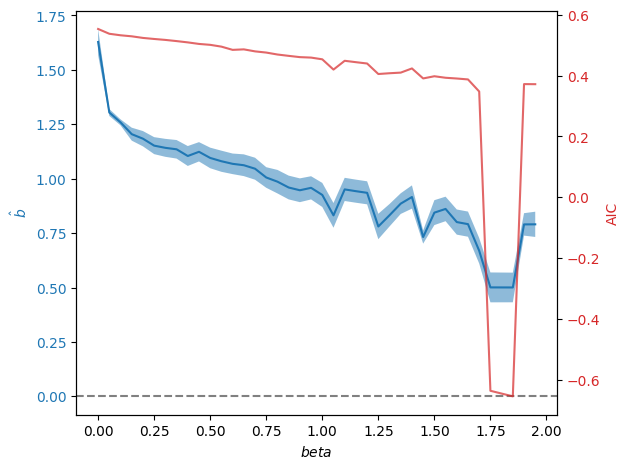

In [83]:
### Plotting
t = beta_vector
data1 = g
data2 = adj_r2

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('$beta$')
ax1.set_ylabel('$\hat{b}$', color=color)
ax1.plot(t, data1, color=color)
ax1.axhline(y=0.0, color='gray', linestyle='--')
ax1.fill_between(t, data1-g_errors, data1+g_errors, alpha = 0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('AIC', color=color )  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, alpha = 0.7)
ax2.tick_params(axis='y', labelcolor=color)



fig.tight_layout()
#fig.savefig('AIC_b_estimate.png', dpi = 300)

In [112]:
# Bootstrap the standard errors
block_length = int(np.floor(len(merged_df)*0.6))
N_bootstraps = 2000
params_bootstrapped = np.zeros((N_bootstraps, 3))
adj_r2 = np.zeros((N_bootstraps, 1))
for i in range(N_bootstraps):
    
    start = np.random.randint(0, merged_df.shape[0] - block_length)
    # Select the block
    
    estimation_df_boost = merged_df.iloc[start:start + block_length]
    x = [estimation_df_boost['x0'], estimation_df_boost['x1'], estimation_df_boost['x2'], estimation_df_boost['x3'], estimation_df_boost['x4'], estimation_df_boost['x5'], estimation_df_boost['x6']]
    y = estimation_df_boost['y']
    try:
        params, pcov = curve_fit(LSTM_full, x, y, p0 = [0.5,0.5,0.8], bounds = ((-10.0, -10.0 ,0.0), (10.0, 10.0, 10.0)))
        #params, pcov = curve_fit(two_type_beta_fixed, x, y, p0 = [0.5,0.5])
    except:
        params, pcov = np.zeros(3), np.zeros((3,3))
        #params, pcov = np.zeros(2), np.zeros((2,2))
    params_bootstrapped[i, :] = params
    #y_pred = objevtive_function(x, *params)
    y_pred = LSTM_full(x, *params)
    residuals = y_pred - y
    rss = np.sum((residuals)**2)
    tss = np.sum((y- np.mean(y))**2)
    n = len(y)
    k = len(params)
    r_squared = 1 - (rss / tss)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
    adj_r2[i,:] = adj_r_squared
    if i % 10 == 0:
        print("iteration",i ,"of 2000")

C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\2647756047.py:35: RuntimeWarning: overflow encountered in exp
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\2647756047.py:35: RuntimeWarning: invalid value encountered in divide
  frac1 = np.exp(beta*prof1)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\2647756047.py:36: RuntimeWarning: overflow encountered in exp
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\2647756047.py:37: RuntimeWarning: overflow encountered in exp
  frac3 = np.exp(beta*prof3)/(np.exp(beta*prof1) + np.exp(beta*prof2) + np.exp(beta*prof3))
C:\Users\tomma\AppData\Local\Temp\ipykernel_9920\2647756047.py:36: RuntimeWarning: invalid value encountered in divide
  frac2 = np.exp(beta*prof2)/(np.exp(beta*prof1) + np.exp(bet

iteration 0 of 2000
iteration 10 of 2000
iteration 20 of 2000
iteration 30 of 2000
iteration 40 of 2000
iteration 50 of 2000
iteration 60 of 2000
iteration 70 of 2000
iteration 80 of 2000
iteration 90 of 2000
iteration 100 of 2000
iteration 110 of 2000
iteration 120 of 2000
iteration 130 of 2000
iteration 140 of 2000
iteration 150 of 2000
iteration 160 of 2000
iteration 170 of 2000
iteration 180 of 2000
iteration 190 of 2000
iteration 200 of 2000
iteration 210 of 2000
iteration 220 of 2000
iteration 230 of 2000
iteration 240 of 2000
iteration 250 of 2000
iteration 260 of 2000
iteration 270 of 2000
iteration 280 of 2000
iteration 290 of 2000
iteration 300 of 2000
iteration 310 of 2000
iteration 320 of 2000
iteration 330 of 2000
iteration 340 of 2000
iteration 350 of 2000
iteration 360 of 2000
iteration 370 of 2000
iteration 380 of 2000
iteration 390 of 2000
iteration 400 of 2000
iteration 410 of 2000
iteration 420 of 2000
iteration 430 of 2000
iteration 440 of 2000
iteration 450 of 2000

In [113]:
# Calculate the standard errors and confidence intervals
params_bootstrapped = params_bootstrapped[~np.all(params_bootstrapped == 0, axis=1)]
params_mean = np.nanmean(params_bootstrapped, axis=0)
params_std = np.nanstd(params_bootstrapped, axis=0)
params_lower = np.percentile(params_bootstrapped, 2.5, axis=0)
params_upper = np.percentile(params_bootstrapped, 97.5, axis=0)
mean_adj_r2 = np.mean(adj_r2)
print(params_mean, params_mean/params_std, mean_adj_r2)

[1.41338484 0.01465604 0.00728978] [8.5764277  1.41736433 0.49703655] 0.46795397667406086


# Check if Linear Regression 

In [124]:
# Create the dataset
i = 7
estimation_df = (data.loc[:,['Close']])
estimation_df['daily_rate'] = R.values
estimation_df['Sentiment'] = df.compound + (1 - df.compound.min())
estimation_df['rolling_Sentiment'] = np.log(estimation_df.Sentiment) - np.log(estimation_df.Sentiment.rolling(i).mean()) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
#given_date = pd.to_datetime("2019-12-1")
#estimation_df = estimation_df[estimation_df.index > given_date]
estimation_df['deviation'] = np.log(estimation_df.Close) - np.log(estimation_df.Close.rolling(i).mean())
estimation_df['y'] = np.log(1+estimation_df.daily_rate) + (estimation_df.deviation)
estimation_df['x0'] = estimation_df.deviation.shift(1)
estimation_df['x1'] = estimation_df.rolling_Sentiment.shift(1)
estimation_df = estimation_df.dropna()

In [125]:
y = estimation_df.y
X = estimation_df.loc[:,["x0", "x1"]]

In [126]:
mod = sm.OLS(y, X)

In [127]:
res = mod.fit()

In [128]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.582
Model:                            OLS   Adj. R-squared (uncentered):              0.581
Method:                 Least Squares   F-statistic:                              797.1
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                   9.82e-218
Time:                        19:25:21   Log-Likelihood:                          2275.8
No. Observations:                1149   AIC:                                     -4548.
Df Residuals:                    1147   BIC:                                     -4538.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [293]:
from scipy.stats import levy_stable

In [331]:
data = np.array(residuals)
alpha, beta, loc, scale = levy_stable._fitstart(data)
params = levy_stable.fit(data, floc = 0, fscale = scale)

In [332]:
params

(1.53800655127088, 0.04547680510751753, 0, 0.015460149351139183)

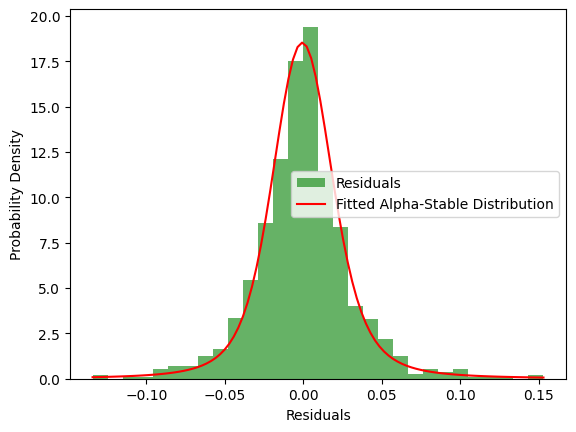

In [334]:
# Histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Residuals")
x = np.linspace(min(data), max(data), 100)
pdf = levy_stable.pdf(x, *params)
plt.plot(x, pdf, 'r', label="Fitted Alpha-Stable Distribution")
plt.xlabel("Residuals")
plt.ylabel("Probability Density")
plt.legend()
#plt.show()
plt.savefig("residuals_alpha_stable.png")